# Challenge de Clasificación Biomédica con IA

Grupo: Ivan Rodriguez

Líder: Ivan Yang Rodriguez Carranza.

Correo: ivanrodcar@outlook.com

## Configuración

**Bibliotecas**

In [43]:
import os
from dotenv import load_dotenv
import dspy
import pandas as pd
import random

# Bibliotecas para análisis exploratorio
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

**Parámetros**

In [16]:
# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Carpeta de programas
PROGRAMS_FOLDER = "programs"

# Obtener el ID del modelo desde el entorno o usar el valor por defecto
MODEL_ID = "openai/gpt-4.1-nano"
TEMPERATURE = 1

# Inicializar el modelo de lenguaje DSPy
lm = dspy.LM(MODEL_ID, temperature=TEMPERATURE)

# Configura DSPy con el modelo de lenguaje
dspy.configure(lm=lm)

## Análisis exploratorio

📊 Dataset: 3,565 papers | Columnas: ['title', 'abstract', 'group'] | Sin faltantes: 0
🏷️ Distribución: Neurological: 1,785 (50.1%) | Hepatorenal: 1,091 (30.6%) | Cardiovascular: 1,268 (35.6%) | Oncological: 601 (16.9%)
⚠️ Multi-label: 1,092 (30.6%) | Promedio: 1.33 | Palabras título/abstract: 8.7/100.1


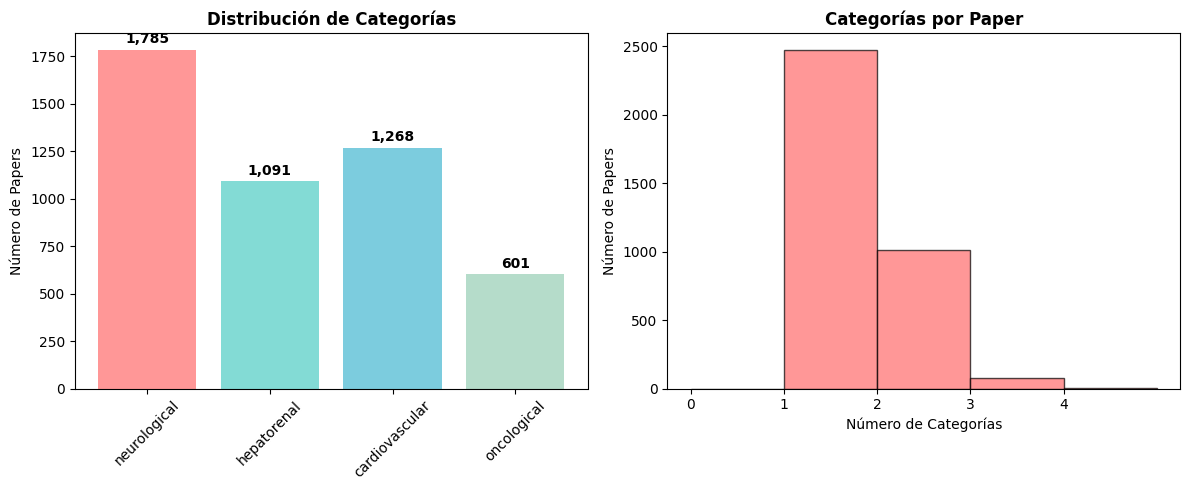

In [ ]:
df = pd.read_csv("/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/data/challenge_data-18-ago.csv", delimiter=';')
categories = ['neurological', 'hepatorenal', 'cardiovascular', 'oncological']
category_df = pd.DataFrame([[cat in row['group'].split('|') if pd.notna(row['group']) else [] for cat in categories] for _, row in df.iterrows()], columns=categories)

print(f"📊 Dataset: {len(df):,} papers | Columnas: {list(df.columns)} | Sin faltantes: {df.isnull().sum().sum()}")
print(f"🏷️ Distribución: " + " | ".join([f"{cat.capitalize()}: {category_df[cat].sum():,} ({category_df[cat].sum()/len(df)*100:.1f}%)" for cat in categories]))
papers_multi, avg_cat = (category_df.sum(axis=1) > 1).sum(), category_df.sum(axis=1).mean()
print(f"⚠️ Multi-label: {papers_multi:,} ({papers_multi/len(df)*100:.1f}%) | Promedio: {avg_cat:.2f} | Palabras título/abstract: {df['title'].str.split().str.len().mean():.1f}/{df['abstract'].str.split().str.len().mean():.1f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
counts, colors = [category_df[cat].sum() for cat in categories], ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
ax1.bar(categories, counts, color=colors, alpha=0.7); ax1.set_title('Distribución de Categorías', fontweight='bold'); ax1.set_ylabel('Número de Papers'); ax1.tick_params(axis='x', rotation=45)
[ax1.text(i, count + 20, f'{count:,}', ha='center', va='bottom', fontweight='bold') for i, count in enumerate(counts)]
ax2.hist(category_df.sum(axis=1), bins=range(0, 6), alpha=0.7, color='#FF6B6B', edgecolor='black'); ax2.set_title('Categorías por Paper', fontweight='bold'); ax2.set_xlabel('Número de Categorías'); ax2.set_ylabel('Número de Papers'); ax2.set_xticks(range(0, 5))
plt.tight_layout(); plt.show()


### 🤔 Reflexiones sobre los datos

Viendo estos gráficos, hay algunas cosas que me llaman la atención:

**Lo que me parece interesante:**
- Neurological se lleva la mitad de los papers (50.1%) mientras que oncológicos apenas llegan al 17%. Esto me hace pensar que el modelo va a tender a clasificar todo como neurológico si no tenemos cuidado.

- Casi un tercio de los papers (30.6%) tienen múltiples etiquetas. Esto tiene sentido en medicina - un estudio sobre derrames cerebrales puede ser tanto neurológico como cardiovascular. El reto va a ser que el modelo entienda estas conexiones.

- Los títulos son súper cortos (8 palabras promedio) y los abstracts tampoco son novelones (100 palabras). Va a ser complicado extraer suficiente información semántica de tan poco texto.

**Lo que esto significa para nuestro clasificador:**
- Definitivamente necesitamos métricas que no se dejen engañar por el desbalance de clases
- No podemos simplificar esto a "una etiqueta por paper" - la naturaleza multi-label es fundamental
- Probablemente tengamos que ser muy inteligentes con cómo procesamos estos textos cortos para sacar el máximo jugo


## Preprocesamiento

Se realiza el siguiente procesamiento de los datos:

1. Se cargan los datos desde el archivo CSV.
2. Se definen las categorías posibles.
3. Se crea el dataset de dspy concatenando título y resumen como 'paper' y transformando 'group' a dict.
4. Se mezclan los datos.
5. Se dividen los datos en train, val y test.

In [ ]:
def init_dataset():
    # Cargar desde el archivo CSV
    csv_path = "/Users/ivan/Workspace/dspy-projects/dspy-biomedic-papers-classifier/data/challenge_data-18-ago.csv"
    df = pd.read_csv(csv_path, delimiter=';')
    
    # Definir todas las categorías posibles
    categories = ['neurological', 'hepatorenal', 'cardiovascular', 'oncological']
    
    # Crear el dataset de dspy concatenando título y resumen como 'paper' y transformando 'group' a dict
    dspy_dataset = [
        dspy.Example({
            "paper": f"Title: {row['title']}\nAbstract: {row['abstract']}",
            "result": {cat: cat in row['group'].split('|') for cat in categories},
        }).with_inputs("paper")
        for _, row in df.iterrows()
    ]
    
    random.Random(0).shuffle(dspy_dataset)
    train_set = dspy_dataset[:int(len(dspy_dataset) * 0.33)]
    val_set = dspy_dataset[int(len(dspy_dataset) * 0.33):int(len(dspy_dataset) * 0.66)]
    test_set = dspy_dataset[int(len(dspy_dataset) * 0.66):]

    return train_set, val_set, test_set

In [4]:
train_set, val_set, test_set = init_dataset()

len(train_set), len(val_set), len(test_set)

(1176, 1176, 1213)

**Ejemplo**

In [37]:
print("Input:")
print(train_set[0]['paper'])

print("\n\nRespuesta esperada:")
for k, v in train_set[0]['result'].items():
    print(f"{k}: {v}")

Input:
Title: Cutting-edge nephron research in breast cancer
Abstract: Aim: To investigate statins effects on dementia through blood urea nitrogen analysis. Methods: 158 elderly patients underwent observational evaluation with gallstone and dialysis assessment. Results: enhanced therapeutic response. Conclusion: safety considerations.


Respuesta esperada:
neurological: False
hepatorenal: True
cardiovascular: False
oncological: False


## Diseño de la solución

Elegí usar la biblioteca DSPy para hacer un clasificador basado en LLMs y optmizar el prompt usando GEPA (https://arxiv.org/abs/2507.19457).

El clasificador recibe como input una cadena de texto que contatena el título y el abstract, y genera la lista de grupos.

In [6]:
from typing import List, Literal

class BiomedicalPaperClassifier(dspy.Signature):
    """
    Read the provided biomedical paper (title and abstract) and determine the set of medical categories applicable to the paper.
    """
    paper: str = dspy.InputField(desc="Title and abstract of the biomedical paper")
    categories: List[Literal["neurological", "hepatorenal", "cardiovascular", "oncological"]] = dspy.OutputField(desc="List of applicable medical categories for this paper")

class BiomedicalClassifierModule(dspy.Module):
    def __init__(self):
        self.classifier = dspy.ChainOfThought(BiomedicalPaperClassifier)
    
    def forward(self, **kwargs):
        paper = kwargs.get('paper')
        result = self.classifier(paper=paper)
        
        # Convert list of categories to boolean dictionary format to match expected output
        category_dict = {
            "neurological": "neurological" in result.categories,
            "hepatorenal": "hepatorenal" in result.categories, 
            "cardiovascular": "cardiovascular" in result.categories,
            "oncological": "oncological" in result.categories
        }
        
        return dspy.Prediction(result=category_dict)
    
    def __call__(self, paper: str):
        return self.forward(paper=paper)

# Initialize the classifier
biomedical_classifier = BiomedicalClassifierModule()


In [ ]:
def score_categories(gold_categories, pred_categories):
    """
    Compute score for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correct = 0
    for k, v in gold_categories.items():
        if v and pred_categories.get(k, False):
            correct += 1
        elif not v and not pred_categories.get(k, False):
            correct += 1
    score = correct / len(gold_categories)
    return score

def metric(example, pred, trace=None, pred_name=None, pred_trace=None):
    """
    Computes a score based on agreement between prediction and gold standard for categories.
    Returns the score (float).
    """
    # Parse gold standard from example (already a dict in our case)
    gold = example['result']

    # Compute score for categories module only
    score_categories_val = score_categories(gold, pred.result)

    # Since we only have categories, the total score is just the categories score
    total = score_categories_val

    return total


**Evaluación del prompt base**

In [8]:
evaluate = dspy.Evaluate(
    devset=test_set,
    metric=metric,
    num_threads=32,
    display_table=True,
    display_progress=True
)

evaluate(biomedical_classifier)

Average Metric: 974.25 / 1213 (80.3%): 100%|██████████| 1213/1213 [00:09<00:00, 124.90it/s] 

2025/08/26 00:36:49 INFO dspy.evaluate.evaluate: Average Metric: 974.25 / 1213 (80.3%)


,paper,example_result,pred_result,metric
0,Title: hepatic and lung cancer: vascular insights Abstract: Hypoth...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Fa...",✔️ [0.250]
1,Title: dementia and thromboembolism: cardiac connections Abstract:...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...","{'neurological': True, 'hepatorenal': False, 'cardiovascular': Tru...",✔️ [0.500]
2,Title: medulloblastoma patterns in lung cancer patients Abstract: ...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Fal...","{'neurological': True, 'hepatorenal': False, 'cardiovascular': Tru...",✔️ [0.750]
3,Title: endometrial cancer pathways in chronic kidney disease Abstr...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Fal...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Fa...",✔️ [0.750]
4,Title: Novel insights into hepatitis and hepatoma Abstract: Aim: T...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Fal...","{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...",✔️ [0.500]
...,...,...,...,...
1208,Title: angina and dementia: vascular insights Abstract: Background...,"{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...","{'neurological': True, 'hepatorenal': False, 'cardiovascular': Tru...",✔️ [0.750]
1209,Title: Oncological frontiers: angina pectoris Abstract: Hypothesis...,"{'neurological': False, 'hepatorenal': False, 'cardiovascular': Fa...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.500]
1210,Title: echocardiography reveals liver cirrhosis secrets Abstract: ...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Tru...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.750]
1211,Title: Blood pressure response to chronic low-dose intrarenal nora...,"{'neurological': True, 'hepatorenal': True, 'cardiovascular': True...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.500]


EvaluationResult(score=80.32, results=<list of 1213 results>)

In [9]:
def feedback_categories(gold_categories, pred_categories):
    """
    Generate feedback for the categories module.
    Uses the same match/mismatch logic as category accuracy in the score.
    """
    correctly_included = [k for k, v in gold_categories.items() if v and pred_categories.get(k, False)]
    incorrectly_included = [k for k, v in gold_categories.items() if not v and pred_categories.get(k, False)]
    incorrectly_excluded = [k for k, v in gold_categories.items() if v and not pred_categories.get(k, False)]
    correctly_excluded = [k for k, v in gold_categories.items() if not v and not pred_categories.get(k, False)]  # For completeness in accuracy check

    # Recompute category accuracy (matches score logic)
    score = (len(correctly_included) + len(correctly_excluded)) / len(gold_categories)

    if score == 1.0:
        fb_text = f"The category classification is perfect. You correctly identified that the paper falls under the following categories: `{repr(correctly_included)}`."
    else:
        fb_text = f"The category classification is not perfect. You correctly identified that the paper falls under the following categories: `{repr(correctly_included)}`.\n"
        if incorrectly_included:
            fb_text += f"However, you incorrectly identified that the paper falls under the following categories: `{repr(incorrectly_included)}`. The paper DOES NOT fall under these categories.\n"
        if incorrectly_excluded:
            prefix = "Additionally, " if incorrectly_included else "However, "
            fb_text += f"{prefix}you didn't identify the following categories that the paper actually falls under: `{repr(incorrectly_excluded)}`.\n"
        fb_text += "Think about how you could have reasoned to get the correct category labels."
    return fb_text, score

def metric_with_feedback(example, pred, trace=None, pred_name=None, pred_trace=None):
    """
    Computes a score based on agreement between prediction and gold standard for categories.
    Optionally provides feedback text for the categories predictor module, using the same comparison logic as the score.
    Returns a dspy.Prediction with score (float) and feedback (str).
    """
    # Parse gold standard from example (already a dict in our case)
    gold = example['result']

    # Compute feedback and score for categories module
    fb_categories, score_categories = feedback_categories(gold, pred.result)

    # Since we only have categories, the total score is just the categories score
    total = score_categories

    if pred_name is None:
        return total

    elif pred_name == 'classifier.predict':
        feedback = fb_categories

    return dspy.Prediction(score=total, feedback=feedback)


In [10]:
from dspy import GEPA

optimizer = GEPA(
    metric=metric_with_feedback,
    auto="heavy",
    num_threads=32,
    track_stats=True,
    use_merge=False,
    reflection_lm=dspy.LM(model="gpt-5", temperature=1.0, max_tokens=32000)
)

In [11]:
try:
    optimized_program = optimizer.compile(
        biomedical_classifier,
        trainset=train_set,
        valset=val_set,
    )
except Exception as e:
    print(e)

2025/08/26 00:36:49 INFO dspy.teleprompt.gepa.gepa: Running GEPA for approx 9267 metric calls of the program. This amounts to 3.94 full evals on the train+val set.
2025/08/26 00:36:49 INFO dspy.teleprompt.gepa.gepa: Using 1176 examples for tracking Pareto scores. You can consider using a smaller sample of the valset to allow GEPA to explore more diverse solutions within the same budget.
2025/08/26 00:36:57 INFO dspy.evaluate.evaluate: Average Metric: 961.75 / 1176 (81.8%)
2025/08/26 00:36:57 INFO dspy.teleprompt.gepa.gepa: Iteration 0: Base program full valset score: 0.8178146258503401
2025/08/26 00:36:57 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Selected program 0 score: 0.8178146258503401
2025/08/26 00:36:57 WARNING dspy.primitives.module: Calling module.forward(...) on BiomedicalClassifierModule directly is discouraged. Please use module(...) instead.


Average Metric: 3.00 / 3 (100.0%): 100%|██████████| 3/3 [00:00<00:00, 124.20it/s]

2025/08/26 00:36:57 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 3 (100.0%)
2025/08/26 00:36:58 INFO dspy.teleprompt.gepa.gepa: Iteration 1: All subsample scores perfect. Skipping.
2025/08/26 00:36:58 INFO dspy.teleprompt.gepa.gepa: Iteration 1: Reflective mutation did not propose a new candidate
2025/08/26 00:36:58 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Selected program 0 score: 0.8178146258503401
2025/08/26 00:36:58 WARNING dspy.primitives.module: Calling module.forward(...) on BiomedicalClassifierModule directly is discouraged. Please use module(...) instead.



Average Metric: 2.25 / 3 (75.0%): 100%|██████████| 3/3 [00:00<00:00, 138.72it/s]

2025/08/26 00:36:58 INFO dspy.evaluate.evaluate: Average Metric: 2.25 / 3 (75.0%)
2025/08/26 00:36:58 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Proposed new text for classifier.predict: Task
You will read a biomedical paper’s title and abstract and assign all applicable medical categories to that paper.

Input format
- The input will contain a single “paper” with:
  - Title: <string>
  - Abstract: <string>

Output format
- Provide two fields:
  - reasoning: 2–5 concise sentences that justify the category choices by referencing the key conditions, organs/systems, outcomes, or mechanisms mentioned in the title/abstract.
  - categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include all applicable categories (multi-label).

General approach
1) Use both the title and abstract to identify:
   - The primary condition(s) or outcomes (e.g., myocardial infarction, stroke, thrombosis).
   - The organ system(s) or pathophysiological domains involved (

2025/08/26 00:37:07 INFO dspy.evaluate.evaluate: Average Metric: 956.5 / 1176 (81.3%)
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Full valset score for new program: 0.8133503401360545
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Full train_val score for new program: 0.8133503401360545
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 2: Individual valset scores for new program: [0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 0.75, 0.75, 0.5, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 0.75, 1.0, 0.75, 0.5, 1.0, 0.75, 0.75, 0.75, 1.0, 0.5, 0.5, 0.75, 1.0, 1.0, 0.25, 1.0, 0.75, 0.5, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 0.25, 0.75, 1.0, 1.0, 1.0, 0.5, 1.0, 0.75, 0.75, 0.5, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75,

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:00<00:00, 133.27it/s]

2025/08/26 00:37:07 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 3: Proposed new text for classifier.predict: Task
Classify a biomedical paper’s title and abstract into all applicable medical categories.

Input format
- The input contains a single paper with:
  - Title: <string>
  - Abstract: <string>

Output format
- Provide two fields:
  - reasoning: 2–5 concise sentences justifying the category choices by referencing the key conditions, organs/systems, outcomes, or mechanisms from the title/abstract.
  - categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include all applicable categories (multi-label).

General approach
1) Use both the title and abstract to identify:
   - The primary condition(s) or outcomes (e.g., myocardial infarction, stroke, carcinogenesis, thrombosis).
   - The organ system(s) or pathophysiological domains involved (heart/vasculature, brain/n


Average Metric: 3.00 / 3 (100.0%): 100%|██████████| 3/3 [00:00<00:00, 210.77it/s]

2025/08/26 00:37:07 INFO dspy.evaluate.evaluate: Average Metric: 3.0 / 3 (100.0%)
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 4: All subsample scores perfect. Skipping.
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 4: Reflective mutation did not propose a new candidate
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Selected program 0 score: 0.8178146258503401
2025/08/26 00:37:07 WARNING dspy.primitives.module: Calling module.forward(...) on BiomedicalClassifierModule directly is discouraged. Please use module(...) instead.



Average Metric: 2.00 / 3 (66.7%): 100%|██████████| 3/3 [00:00<00:00, 69.34it/s]

2025/08/26 00:37:07 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 3 (66.7%)
2025/08/26 00:37:07 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Proposed new text for classifier.predict: Task
- Read a biomedical paper’s title and abstract and assign all applicable medical categories from a fixed set.

Allowed categories (lowercase strings only)
- cardiovascular
- neurological
- hepatorenal
- oncological

Inputs
- You will receive a “paper” object containing:
  - Title: <string>
  - Abstract: <string>

Definition of “applicable”
- A category is applicable if the paper’s hypothesis, primary question, population, intervention, outcomes/endpoints, or proposed/measured mechanisms are directly within that domain.
- Mentions that are only background/context, incidental, or not tied to what is actually studied do NOT make a category applicable.
- Use both title and abstract, but prioritize concrete content in the abstract if they conflict.

Decision rules
1) Read title and abstract. Extract:


2025/08/26 00:37:17 INFO dspy.evaluate.evaluate: Average Metric: 976.0 / 1176 (83.0%)
2025/08/26 00:37:17 INFO dspy.teleprompt.gepa.gepa: Iteration 5: New program is on the linear pareto front
2025/08/26 00:37:17 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Full valset score for new program: 0.8299319727891157
2025/08/26 00:37:17 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Full train_val score for new program: 0.8299319727891157
2025/08/26 00:37:17 INFO dspy.teleprompt.gepa.gepa: Iteration 5: Individual valset scores for new program: [0.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 0.5, 0.75, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 0.25, 1.0, 0.75, 0.75, 0.75, 1.0, 0.75, 0.75, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.75, 1.0, 0.75, 0.75, 1.0, 1.0, 0.5, 1.0, 1.0, 0.75, 1.0, 0.75, 0.75, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:00<00:00, 127.02it/s]

2025/08/26 00:37:17 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)
2025/08/26 00:37:17 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Proposed new text for classifier.predict: Task
- Read a biomedical paper’s title and abstract and assign all applicable medical categories from a fixed set.

Allowed categories (lowercase strings only)
- cardiovascular
- neurological
- hepatorenal
- oncological

Inputs
- You will receive a “paper” object containing:
  - Title: <string>
  - Abstract: <string>

What makes a category “applicable”
- A category is applicable if the paper’s hypothesis, primary question, population, intervention, outcomes/endpoints, or proposed/measured mechanisms are directly within that domain.
- Mentions that are only background/context, incidental, or not tied to what is actually studied do NOT make a category applicable.
- Use both title and abstract, but prioritize concrete, study-related content in the abstract if they conflict.

Decision process
1) Extract f

2025/08/26 00:37:26 INFO dspy.evaluate.evaluate: Average Metric: 969.5 / 1176 (82.4%)
2025/08/26 00:37:26 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Full valset score for new program: 0.8244047619047619
2025/08/26 00:37:26 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Full train_val score for new program: 0.8244047619047619
2025/08/26 00:37:26 INFO dspy.teleprompt.gepa.gepa: Iteration 6: Individual valset scores for new program: [0.25, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.5, 0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 0.75, 0.75, 0.75, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 0.25, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.5, 1.0, 1.0, 0.25, 0.25, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.75, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.5, 0.75, 0.75, 0

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:00<00:00, 145.87it/s]

2025/08/26 00:37:26 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)
2025/08/26 00:37:26 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Proposed new text for classifier.predict: Task
You will read a biomedical paper’s title and abstract and assign all applicable medical categories to that paper.

Input format
- The input will contain a single “paper” with:
  - Title: <string>
  - Abstract: <string>

Output format
- Provide two fields:
  - reasoning: 2–5 concise sentences that justify the category choices by referencing the key conditions, organs/systems, outcomes, or mechanisms mentioned in the title/abstract.
  - categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include all applicable categories (multi-label).

Core categories to use
- 'cardiovascular'
- 'neurological'
- 'hepatorenal'
- Optionally, 'oncology' may be used but only if the study’s central focus is oncologic (see rules below).

General approach
1) Use both the title an

2025/08/26 00:37:35 INFO dspy.evaluate.evaluate: Average Metric: 984.0 / 1176 (83.7%)
2025/08/26 00:37:35 INFO dspy.teleprompt.gepa.gepa: Iteration 7: New program is on the linear pareto front
2025/08/26 00:37:35 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Full valset score for new program: 0.8367346938775511
2025/08/26 00:37:35 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Full train_val score for new program: 0.8367346938775511
2025/08/26 00:37:35 INFO dspy.teleprompt.gepa.gepa: Iteration 7: Individual valset scores for new program: [0.5, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 0.75, 0.5, 0.5, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.0, 0.5, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 0.75, 1.0, 0.75, 1.0, 0.5, 0.75, 1.0, 1.0, 0.75, 0.25, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 1.0, 1.0, 0.75, 0.75, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.75, 1.0, 0.75, 1.0, 0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 0.75, 0.75, 

Average Metric: 2.75 / 3 (91.7%): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s] 

2025/08/26 00:37:37 INFO dspy.evaluate.evaluate: Average Metric: 2.75 / 3 (91.7%)


2025/08/26 00:38:25 INFO dspy.teleprompt.gepa.gepa: Iteration 8: Proposed new text for classifier.predict: Task
Read a biomedical paper’s title and abstract and assign all applicable medical categories to that paper.

Input format
- The input contains a single “paper” with:
  - Title: <string>
  - Abstract: <string>

Output format
- Provide two fields:
  - reasoning: 2–5 concise sentences that justify the category choices by referencing the key conditions, organs/systems, outcomes, or mechanisms mentioned in the title/abstract. Focus on the study’s objectives, outcomes, and mechanistic emphasis.
  - categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include every applicable category (multi-label).

Core category labels to use (exact strings)
- 'cardiovascular'
- 'neurological'
- 'hepatorenal'
- 'oncological' (use only when the study’s central focus is oncologic; see rules)

General decision framework
1) Use both the title and abstract to ident

Average Metric: 2.75 / 3 (91.7%): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s] 

2025/08/26 00:38:29 INFO dspy.evaluate.evaluate: Average Metric: 2.75 / 3 (91.7%)


2025/08/26 00:40:03 INFO dspy.teleprompt.gepa.gepa: Iteration 9: Proposed new text for classifier.predict: Task
Classify a biomedical paper’s title and abstract into applicable medical categories.

Input format
- A single paper object with:
  - Title: <string>
  - Abstract: <string>

Output format
- reasoning: 2–5 concise sentences justifying the category choices by citing the key conditions, organs/systems, outcomes, or mechanisms from the title/abstract.
- categories: a JSON-like Python list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Multi-label—include all that apply.

Core categories
- 'cardiovascular'
- 'neurological'
- 'hepatorenal'
- 'oncology' (use only when the study’s central focus is oncologic; see rules)

General approach
1) Use both the title and abstract to identify:
   - Primary condition(s) or outcomes (e.g., myocardial infarction, stroke, thrombosis, seizures, creatinine change).
   - Organ systems or pathophysiological domains (heart/vasculature,

Average Metric: 2.75 / 3 (91.7%): 100%|██████████| 3/3 [00:01<00:00,  2.41it/s] 

2025/08/26 00:40:06 INFO dspy.evaluate.evaluate: Average Metric: 2.75 / 3 (91.7%)


2025/08/26 00:40:54 INFO dspy.teleprompt.gepa.gepa: Iteration 10: Proposed new text for classifier.predict: Task
- Read a biomedical paper’s title and abstract and assign all applicable medical categories from a fixed set.

Allowed categories (lowercase strings only)
- cardiovascular
- neurological
- hepatorenal
- oncological

Inputs
- You will receive a “paper” object containing:
  - Title: <string>
  - Abstract: <string>

What makes a category “applicable”
- A category is applicable only if the paper’s hypothesis, primary question, population definition tied to studied disease focus, interventions/exposures, outcomes/endpoints, or proposed/measured mechanisms are directly within that domain.
- Mentions that are only background/context, incidental, or not tied to what is actually studied do NOT make a category applicable.
- Use both title and abstract, but prioritize concrete, study-related content in the abstract if they conflict. Do NOT assign based on title alone if the abstract po

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s] 

2025/08/26 00:41:50 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)


2025/08/26 00:42:31 INFO dspy.teleprompt.gepa.gepa: Iteration 11: Proposed new text for classifier.predict: Task
Classify a biomedical paper into all applicable medical categories based on its title and abstract.

Input format
- The input contains a single paper with:
  - Title: <string>
  - Abstract: <string>

Output format
- Provide two fields:
  - reasoning: 2–5 concise sentences justifying the chosen categories by citing the key conditions, organs/systems, outcomes, or mechanisms from the title/abstract.
  - categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include every applicable category (multi-label).

Allowed category set
- cardiovascular
- neurological
- hepatorenal
- oncological

General approach
1) Read both the title and abstract to identify:
   - Primary condition(s) or outcomes (e.g., myocardial infarction, stroke, thrombosis, hepatitis, nephritis).
   - The organ system(s) or pathophysiological domains involved (heart/vasculat

Average Metric: 2.75 / 3 (91.7%): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s] 

2025/08/26 00:43:24 INFO dspy.evaluate.evaluate: Average Metric: 2.75 / 3 (91.7%)


2025/08/26 00:44:14 INFO dspy.teleprompt.gepa.gepa: Iteration 12: Proposed new text for classifier.predict: Task overview
- Read a biomedical paper’s title and abstract and assign all applicable medical categories from a fixed set.

Allowed categories (lowercase strings only)
- cardiovascular
- neurological
- hepatorenal
- oncological

Inputs
- You will receive a “paper” object containing:
  - Title: <string>
  - Abstract: <string>

Definition of “applicable”
- A category is applicable if the paper’s hypothesis, primary question, population, intervention/exposure, outcomes/endpoints, or proposed/measured mechanisms are directly within that domain.
- Mentions that are only background/context, incidental, or not tied to what is actually studied do NOT make a category applicable.
- Use both title and abstract; prefer concrete study content in the abstract when it is informative and consistent. If the abstract is clearly low-quality (e.g., generic boilerplate, internally inconsistent, or n

Average Metric: 2.50 / 3 (83.3%): 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]

2025/08/26 00:44:18 INFO dspy.evaluate.evaluate: Average Metric: 2.5 / 3 (83.3%)


2025/08/26 00:44:54 INFO dspy.teleprompt.gepa.gepa: Iteration 13: Proposed new text for classifier.predict: You are given a biomedical paper consisting of a Title and an Abstract. Your task is to assign all applicable medical categories to the paper from a fixed, closed set of labels.

Allowed categories (exact strings):
- neurological
- cardiovascular
- hepatorenal
- oncological

General rules
- Read both the title and the abstract, but prioritize the abstract if there is any discrepancy; titles can be misleading.
- Assign zero or more categories. If none of the four categories are clearly supported by the content, return an empty list.
- Use only the allowed labels. Do not invent new categories.
- Base your decision on the main disease/process focus, not merely on the drugs, settings, or procedures mentioned (e.g., transplantation, immunosuppressants).
- If multiple domains are genuinely central, assign multiple categories.

Category guidance and trigger cues
- Neurological:
  - CNS/

Average Metric: 1.75 / 3 (58.3%): 100%|██████████| 3/3 [00:01<00:00,  2.07it/s]

2025/08/26 00:44:57 INFO dspy.evaluate.evaluate: Average Metric: 1.75 / 3 (58.3%)


2025/08/26 00:45:55 INFO dspy.teleprompt.gepa.gepa: Iteration 14: Proposed new text for classifier.predict: Task
Classify a biomedical paper (title + abstract) into one or more organ-system categories.

Input format
- A single “paper” with:
  - Title: <string>
  - Abstract: <string>

Output format
- reasoning: 2–5 concise sentences justifying the labels by citing the paper’s key conditions, organs/systems, outcomes, or mechanisms.
- categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include all applicable categories (multi-label).

Allowed categories
- 'cardiovascular'
- 'neurological'
- 'hepatorenal'
- Optionally, 'oncology' (use only if the study’s central focus is oncologic; see rules below)

General approach
1) Use both the title and abstract, prioritizing the abstract if there is any conflict or if the title is vague/misleading.
2) Identify the paper’s objective(s), primary outcome(s), and mechanistic focus:
   - Conditions/events (e.g., 

In [12]:
for name, pred in optimized_program.named_predictors():
    print("================================")
    print(f"Predictor: {name}")
    print("================================")
    print("Prompt:")
    print(pred.signature.instructions)
    print("*********************************")

Predictor: classifier.predict
Prompt:
Task
Classify a biomedical paper (title + abstract) into one or more organ-system categories.

Input format
- A single “paper” with:
  - Title: <string>
  - Abstract: <string>

Output format
- reasoning: 2–5 concise sentences justifying the labels by citing the paper’s key conditions, organs/systems, outcomes, or mechanisms.
- categories: a JSON-like list of lowercase strings (e.g., ['cardiovascular', 'neurological']). Include all applicable categories (multi-label).

Allowed categories
- 'cardiovascular'
- 'neurological'
- 'hepatorenal'
- Optionally, 'oncology' (use only if the study’s central focus is oncologic; see rules below)

General approach
1) Use both the title and abstract, prioritizing the abstract if there is any conflict or if the title is vague/misleading.
2) Identify the paper’s objective(s), primary outcome(s), and mechanistic focus:
   - Conditions/events (e.g., myocardial infarction, stroke, cirrhosis, kidney injury).
   - Target 

In [13]:
evaluate(optimized_program)

Average Metric: 1023.75 / 1213 (84.4%): 100%|██████████| 1213/1213 [00:50<00:00, 24.10it/s]

2025/08/26 00:47:38 INFO dspy.evaluate.evaluate: Average Metric: 1023.75 / 1213 (84.4%)


,paper,example_result,pred_result,metric
0,Title: hepatic and lung cancer: vascular insights Abstract: Hypoth...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...","{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...",✔️ [1.000]
1,Title: dementia and thromboembolism: cardiac connections Abstract:...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Tru...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.750]
2,Title: medulloblastoma patterns in lung cancer patients Abstract: ...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Fal...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Fa...",✔️ [0.500]
3,Title: endometrial cancer pathways in chronic kidney disease Abstr...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Fal...","{'neurological': True, 'hepatorenal': False, 'cardiovascular': Fal...",✔️ [0.750]
4,Title: Novel insights into hepatitis and hepatoma Abstract: Aim: T...,"{'neurological': False, 'hepatorenal': True, 'cardiovascular': Fal...","{'neurological': False, 'hepatorenal': True, 'cardiovascular': Fal...",✔️ [0.750]
...,...,...,...,...
1208,Title: angina and dementia: vascular insights Abstract: Background...,"{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [1.000]
1209,Title: Oncological frontiers: angina pectoris Abstract: Hypothesis...,"{'neurological': False, 'hepatorenal': False, 'cardiovascular': Fa...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.500]
1210,Title: echocardiography reveals liver cirrhosis secrets Abstract: ...,"{'neurological': True, 'hepatorenal': False, 'cardiovascular': Tru...","{'neurological': False, 'hepatorenal': True, 'cardiovascular': Fal...",✔️ [0.250]
1211,Title: Blood pressure response to chronic low-dose intrarenal nora...,"{'neurological': True, 'hepatorenal': True, 'cardiovascular': True...","{'neurological': False, 'hepatorenal': False, 'cardiovascular': Tr...",✔️ [0.500]


EvaluationResult(score=84.4, results=<list of 1213 results>)

In [ ]:
# Baseline
biomedical_classifier.save(f"../{PROGRAMS_FOLDER}/biomedical_classifier_base.json", save_program=False)
print(f"Saved biomedical_classifier_base.json to {PROGRAMS_FOLDER}")

# Optimized
optimized_program.save(f"../{PROGRAMS_FOLDER}/biomedical_classifier_optimized.json", save_program=False)
print(f"Saved biomedical_classifier_optimized.json to {PROGRAMS_FOLDER}")

Saved biomedical_classifier_base.json to programs
Saved biomedical_classifier_optimized.json to programs


## Validación